In [1]:
scores = '../out/ko_scores.txt'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=12)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# other imports
import random
import itertools
import numpy as np
import pandas as pd
from scipy import cluster
import fastcluster as fst
import matplotlib.patches as patches

In [4]:
m = pd.read_table(scores, index_col=[0, 2]).sort_index()
genes = None
for s in {x[0] for x in m.index}:
    gs = {x for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
genes = sorted(genes)
m = m.loc[(slice(None), genes),]
p = m.pivot_table(index=['strain', 'gene'],
                  columns='condition',
                  values='score')

In [5]:
c = p.copy(deep=True)
c[np.isnan(c)] = 0.
rl = fst.linkage(c, method='average')
cl = fst.linkage(c.T, method='average')
cmap = sns.diverging_palette(217, 76, l=89, n=100, center="dark", as_cmap=True)
cmap.set_bad(sns.xkcd_rgb['grey'], alpha=0.55)

In [6]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [7]:
cstrains

{'S288C': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 'UWOP': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 'Y55': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 'YPS': (0.596078431372549, 0.3058823529411765, 0.6392156862745098)}

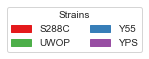

In [8]:
plt.figure(figsize=(2, 0.5))

handles = []
for k, v in sorted(cstrains.items(), key=lambda x: x[0]):
    handles.append(patches.Patch(color=v, label=k))

plt.legend(handles=handles, ncol=int(len(handles)/2),
           loc='center',
           title='Strains')
plt.yticks([])
plt.xticks([])
sns.despine(left=True,
            bottom=True)
plt.savefig('strains_legend.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('strains_legend.svg',
            dpi=300, bbox_inches='tight',
            transparent=True)

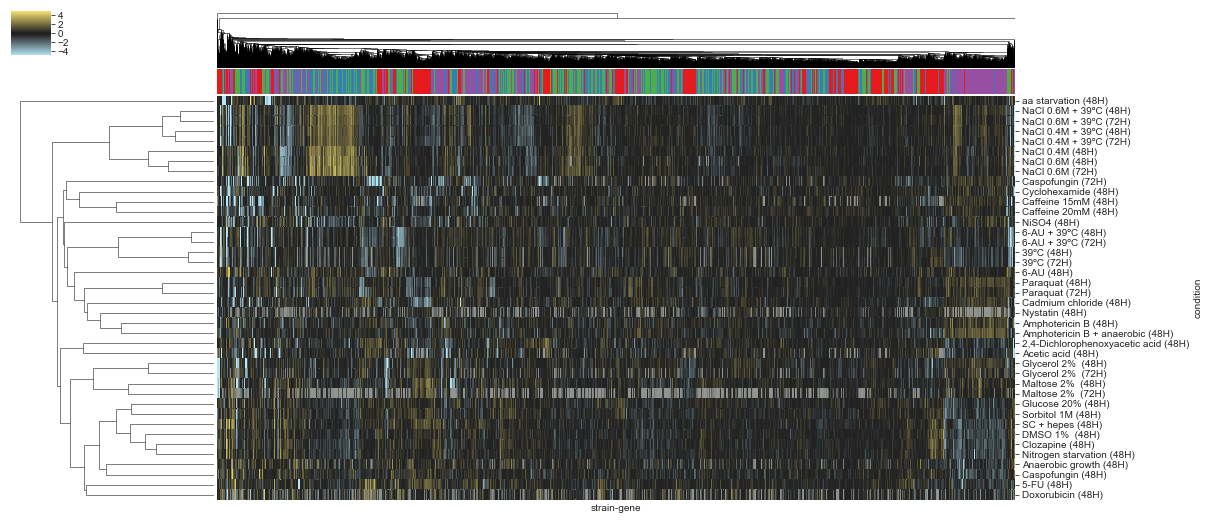

In [9]:
mclust = sns.clustermap(p.T,
                        cmap=cmap,
                        vmax=5,
                        vmin=-5,
                        xticklabels=False,
                        yticklabels=True,
                        row_linkage=cl,
                        col_linkage=rl,
                        figsize=(18, 9),
                        col_colors=[cstrains[x[0]]
                                    for x in p.index]);

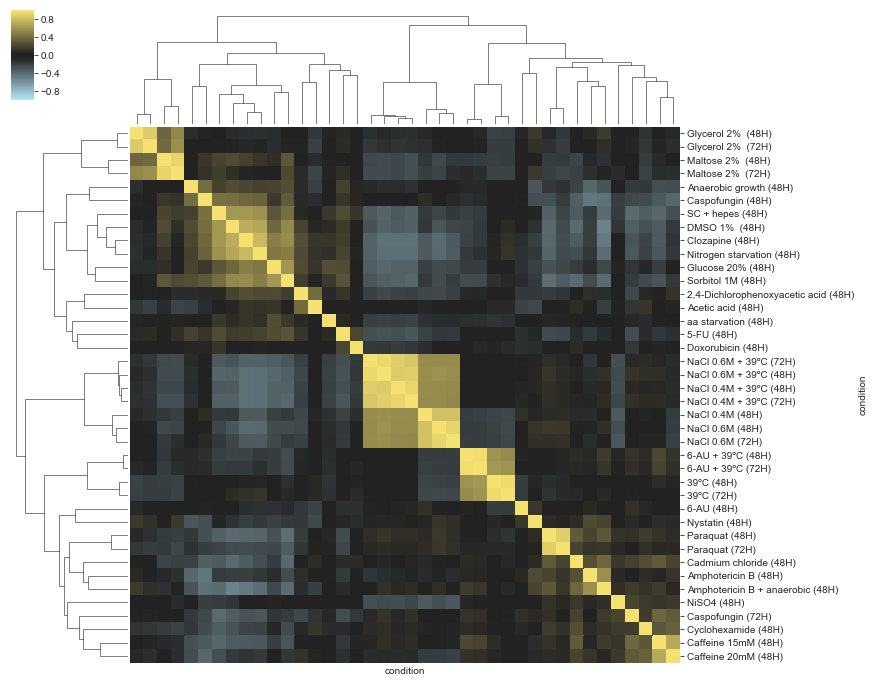

In [10]:
mclust = sns.clustermap(p.corr(),
                        cmap=cmap,
                        vmax=1,
                        vmin=-1,
                        xticklabels=False,
                        yticklabels=True,
                        figsize=(12, 12));

In [11]:
t = []
color = []
co = None
for i, strain in enumerate(strains):
    c = p.loc[strain].copy(deep=True)
    c[np.isnan(c)] = 0.
    rl = fst.linkage(c, method='average')
    rd = cluster.hierarchy.dendrogram(rl, no_plot=True,
                                      color_threshold=-np.inf)
    ro = p.loc[strain].index[rd['leaves']]
    if co is None:
        cl = fst.linkage(c.T, method='average')
        cd = cluster.hierarchy.dendrogram(cl, no_plot=True,
                                          color_threshold=-np.inf)
        co = p.loc[strain].columns[cd['leaves']]
    t.append(p.loc[(strain, ro), co])
    for x in range(p.loc[(strain, ro),].shape[0]):
        color.append(i)
t = pd.concat(t, ignore_index=True)
color = np.array(color)

In [12]:
cmap1 = colors.ListedColormap([cstrains[strain]
                               for strain in strains])

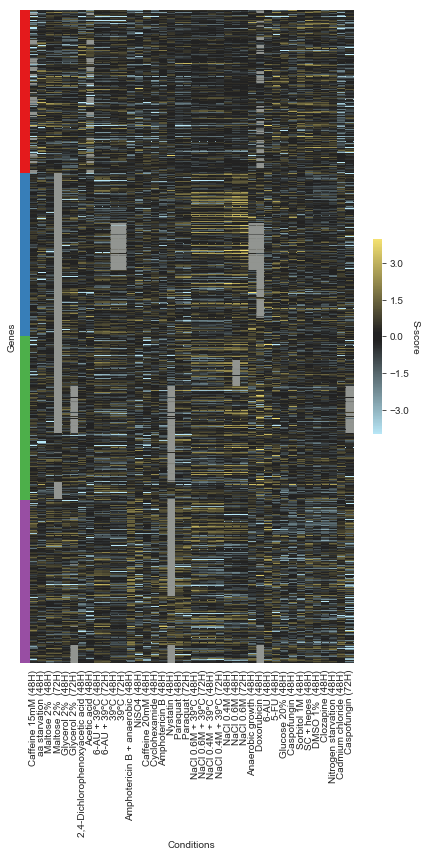

In [13]:
plt.figure(figsize=(7, 12))

gs = plt.GridSpec(1, 2,
                  wspace=0,
                  width_ratios=[0.15, 6])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

plt.sca(ax2)
hm = sns.heatmap(t,
                 cmap=cmap,
                 vmax=4,
                 vmin=-4,
                 yticklabels=False,
                 xticklabels=True,
                 cbar=True,
                 cbar_kws={'fraction': 0.1,
                           'shrink': 0.3})
ax2.collections[0].set_rasterized(True)
plt.xlabel('Conditions')
plt.xticks(rotation=90)
cbar_ax = plt.gcf().axes[-1]
cbar_ax.set_ylabel('S-score', rotation=270, labelpad=10)

plt.sca(ax1)
plt.imshow(color.reshape(-1, 1),
           aspect='auto',
           cmap=cmap1)
plt.yticks([])
plt.xticks([])
sns.despine(left=True,
            bottom=True)
plt.ylabel('Genes')

plt.savefig('heatmap.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);